In [1]:
#pip install mercury

In [2]:
import mercury as mr

In [3]:
mr.PDF("QNN - Technical Writeup.pdf")

**Quanvolutional Neural Networks**

1. PennyLane (pennylane): A library for quantum machine learning that allows defining and running quantum circuits.
2. TensorFlow (tensorflow): A popular library for building and training neural networks.
3. NumPy (numpy): Used for numerical operations.
4. Matplotlib (matplotlib): Used for plotting training and validation metrics.
5. Keras (keras): High-level API for building and training neural networks, included in TensorFlow.

**Gist** : The below code demonstrates a hybrid classical-quantum neural network approach. It uses a reduced version of the MNIST dataset to train a model that includes a quantum layer, which is evaluated within a TensorFlow/Keras framework. While the quantum component is simplified here for demonstration, it showcases how quantum circuits can be integrated into classical machine learning pipelines.

In [4]:
import pennylane as qml
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from silence_tensorflow import silence_tensorflow
silence_tensorflow()


**Load and Preprocess MNIST Dataset**

1. Dataset Loading: MNIST data is loaded with keras.datasets.mnist.load_data(), providing images and labels of handwritten digits.
2. Reduce Dataset Size: Only a small subset of data is used for quicker computations.
3. Normalization: Pixel values are normalized to the range [0, 1].
4. Dimension Expansion: Added a channel dimension to match the expected input shape for CNNs (though not used further in this script).

In [5]:
# Load and preprocess MNIST dataset
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset
n_epochs = 50

mnist_dataset = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()

# Reduce dataset size
x_train = x_train[:n_train]
y_train = y_train[:n_train]
x_test = x_test[:n_test]
y_test = y_test[:n_test]

# Normalize pixel values within 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# Add extra dimension for convolution channels
x_train = np.expand_dims(x_train, axis=-1)  # (n_train, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)    # (n_test, 28, 28, 1)


**Feature Reduction**
1. Images are flattened and reduced to only the first 4 features to fit the input dimension of the quantum circuit. This is a major simplification for demonstration purposes.

In [6]:
# Reduce features to match quantum circuit's requirements
def feature_reduction(x):
    # Flatten the images and use only the first 4 features
    x_flat = x.reshape(x.shape[0], -1)  # Flatten the images
    return x_flat[:, :4]

x_train_reduced = feature_reduction(x_train)
x_test_reduced = feature_reduction(x_test)


**One-Hot Encoding**

1. Labels are converted to a one-hot format suitable for classification tasks, where each label is represented as a vector of length 10.

In [7]:
# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)  # Ensure shape is (n_train, 10)
y_test = to_categorical(y_test, 10)    # Ensure shape is (n_test, 10)


**Define Quantum Circuit**

1.A quantum circuit is defined using PennyLane. It uses angle embedding and entangling layers to process the inputs and weights. The expectation value of **PauliZ(0)** is used as the output.

In [8]:
# Define a quantum circuit
def qnn_circuit(inputs, weights):
    qml.templates.AngleEmbedding(features=inputs, wires=range(4))
    qml.templates.BasicEntanglerLayers(weights, wires=range(4))
    return qml.expval(qml.PauliZ(0))


**Create Quantum Device**

1. A quantum device with 4 qubits is created using PennyLane’s default simulator.

In [9]:
# Create a quantum device
dev = qml.device("default.qubit", wires=4)


**Define Custom Keras Layer for Quantum Computation**

**QuantumLayer Class**: A custom Keras layer is created to handle quantum computations. It includes:
1. Weights Initialization: Trainable parameters for the quantum circuit.
2. Call Method: Converts inputs and weights to tensors, evaluates the quantum circuit, and reshapes the result.

In [10]:
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        # Initialize weights as trainable parameters
        self._weights = self.add_weight(
            shape=(4, 4),  # Adjust shape to match the circuit requirements
            initializer='random_normal',
            trainable=True,
            name='quantum_weights'
        )

    def call(self, inputs):
        # Ensure inputs are in the correct shape and type
        inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
        weights = tf.convert_to_tensor(self._weights, dtype=tf.float32)

        # Define a quantum node
        @qml.qnode(dev, interface='tf')
        def quantum_node(inputs, weights):
            return qnn_circuit(inputs, weights)
        
        # Get results from quantum node
        result = quantum_node(inputs, weights)
        
        # Convert the result back to a TensorFlow tensor and ensure correct shape
        return tf.reshape(result, (-1, 1))  # Ensure output shape is [batch_size, 1]


**Define and Compile the Model**
- Model Definition: A simple sequential model is defined with:
 1. Input Layer: Matches the input shape of the reduced features.
 2. QuantumLayer: Integrates the quantum circuit into the model.
 3. Dense Layer: A softmax layer for classification with 10 output neurons.
- Compilation: The model is compiled using Adam optimizer and categorical crossentropy loss function.

In [11]:
# Define the model
def create_qnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=(4,)),  # Adjust input shape to match feature reduction
        QuantumLayer(),
        tf.keras.layers.Dense(10, activation='softmax')  # Dense layer expects shape [batch_size, 10]
    ])
    return model

# Create and compile the model
model = create_qnn_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


**Train and Evaluate the Model**

1. Training: The model is trained for a specified number of epochs with a batch size of 4 and a validation split of 20%.
2. Evaluation: The model is evaluated on the test set to obtain accuracy.

In [12]:
# Train the model and save history
history = model.fit(x_train_reduced, y_train, epochs=n_epochs, batch_size=4, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(x_test_reduced, y_test)
print(f'Test accuracy: {accuracy}')


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.0000e+00 - loss: 2.27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0662 - loss: 2.2902   ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.0818 - loss: 2.2988 - val_accuracy: 0.3000 - val_loss: 2.2141
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2500 - loss: 2.265 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1483 - loss: 2.284 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1439 - loss: 2.2882 - val_accuracy: 0.3000 - val_loss: 2.2154
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0000e+00 - loss: 2.277 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0823 - loss: 2.3193 - val_accuracy: 0.3000 - val_loss: 2.2179
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2500 - loss: 2.238 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1322 - loss: 2.2793 - val_accuracy: 0.3000 - val_loss: 2.2191
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5000 - loss: 2.199

**Plot Training and Validation Metrics**
1. The training and validation loss and accuracy are plotted to visualize the model’s performance over epochs.

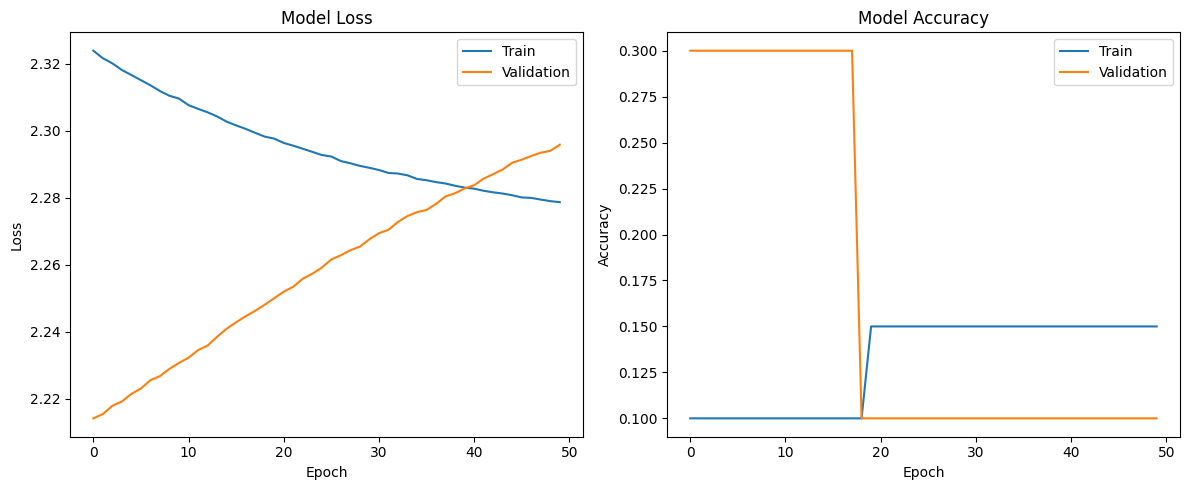

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()
